# tetris_sklearn
ноутбук предназначен для использования в проекте игрового ИИ для игры тетрис на основе sklearn

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import os
import random

WORK_DIR = 'e:\\tetris_ai'

In [101]:
fileList = []
for r in os.listdir(WORK_DIR):
    if r.endswith('.json'):
        fn = os.path.join(WORK_DIR,r)
        fileList.append(fn)
        #print(fn)

пример игрового лога - загрузка, визуализация игрового поля

In [3]:
df1 = pd.read_json(fileList[2])
df1.head()

,figType,figX,figY,figRotation,gameArea
0,1,0,17,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,4,3,16,-2,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,6,1,15,-3,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
3,2,8,16,-1,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4,1,5,17,-1,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [4]:
s = df1.iloc[1]
s

figType                                                        4
figX                                                           3
figY                                                          16
figRotation                                                   -2
gameArea       [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
Name: 1, dtype: object

визуализация игрового поля

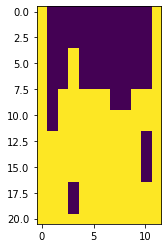

In [5]:
df1 = pd.read_json(random.choice(fileList))
s = df1.iloc[random.randint(0,df1.shape[0])]

area = np.array(s.gameArea,dtype=np.int8)
plt.imshow(area.transpose())
plt.show()

# построние Датасета из файлов с архивом игр

In [66]:
pd.options.mode.chained_assignment = None  # default='warn'

def build_tetris_dataset(figType,figRotation=None,filesToParse=None):
    """ построить датасет для конкретной фигуры"""
    
    if filesToParse is None:
        filesToParse = []
        for r in os.listdir(WORK_DIR):
            if r.endswith('.json'):
                fn = os.path.join(WORK_DIR,r)
                filesToParse.append(fn)
    
    df_all = pd.DataFrame()
    
    # выбираем только нужные нам строки
    for fn in filesToParse:
        df1 = pd.read_json(fn)
        df1 = df1.loc[df1['figType']==figType]
        
        # четыре поворота отображают фигуру в саму себя - отбрасываем лишние обороты
        for i,r in enumerate(df1['figRotation']):  
            df1['figRotation'].iloc[i] = r%4
                
        if not figRotation is None:
            df1 = df1.loc[df1['figRotation']==figRotation]
            
        df_all = pd.concat([df_all,df1],ignore_index = True)
        
    # проходим по строкам, генерируем датасет
    X,y_shift,y_rotate = [],[],[]
    for i,data in df_all.iterrows():
        X.append(np.array(data['gameArea'],dtype=np.int8).reshape(-1))
        y_shift.append(data['figX'])
        y_rotate.append(data['figRotation'])
        
    return np.array(X),np.array(y_shift),np.array(y_rotate)

X,y1,y2 = build_tetris_dataset(4)
print(X.shape) # число объектов в выборке
print(y1.shape)


(399, 252)
(399,)


# Пробуем построить модель ML

In [100]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X,y,_ = build_tetris_dataset(4)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5)

clf_dumb = DummyClassifier().fit(X_train,y_train)
print('dummy score:',clf_dumb.score(X_test,y_test))

clf_LR = LogisticRegressionCV(max_iter=1000).fit(X_train,y_train)
print('LogisticRegression score:',clf_LR.score(X_test,y_test))

clf_SVC = SVC().fit(X_train,y_train)
print('SVC score:',clf_SVC.score(X_test,y_test))

clf_xgb = GradientBoostingClassifier().fit(X_train,y_train)
print('XGB score:',clf_xgb.score(X_test,y_test)) 

y_line = [y_test-clf_LR.predict(X_test),
          y_test-clf_SVC.predict(X_test),
          y_test-clf_xgb.predict(X_test)]

y_labels = ['LogisticRegression','SVC','XGB']

#df_result = pd.DataFrame(y_line,columns = y_labels)
fig = px.line(y=y_line)

fig.show()

dummy score: 0.085


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



LogisticRegression score: 0.15
SVC score: 0.14
XGB score: 0.125


In [95]:
pd.DataFrame?